### Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
import os

#### Importing Dataset

In [3]:
df = pd.read_csv("../dataset/data_with_cluster.csv")

In [5]:
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,User_Score,Cluster,Cluster_Label
0,Grand Theft Auto V,PS3,2013,Action,Take-Two Interactive,7.02,9.09,0.98,3.96,21.04,97.0,8.2,0,Massive / Blockbuster
1,Grand Theft Auto V,X360,2013,Action,Take-Two Interactive,9.66,5.14,0.06,1.41,16.27,97.0,8.1,0,Massive / Blockbuster
2,Grand Theft Auto V,PS4,2014,Action,Take-Two Interactive,3.96,6.31,0.38,1.97,12.61,97.0,8.3,0,Massive / Blockbuster
3,Call of Duty: Ghosts,X360,2013,Shooter,Activision,6.73,2.56,0.04,0.91,10.25,73.0,2.6,0,Massive / Blockbuster
4,Call of Duty: Ghosts,PS3,2013,Shooter,Activision,4.10,3.63,0.38,1.25,9.36,71.0,2.6,0,Massive / Blockbuster


In [6]:
print(f'Data dimuat : {df.shape}')

Data dimuat : (975, 14)


### Data Preparation (Binning)

In [7]:
print("\nMelakukan Binning (Pengelompokan Skor)...")

# Definisi Kategori Skor:
# < 70      : Low
# 70 - 85   : Mid
# > 85      : High
df['Score_Category'] = pd.cut(df['Critic_Score'], 
                              bins=[0, 69, 85, 100], 
                              labels=['Score_Low', 'Score_Mid', 'Score_High'])

# Kita pilih kolom yang mau dicari polanya
# Kita mau cari hubungan antara: Platform, Genre, Kualitas Skor, dan Tingkat Kesuksesan (Cluster)
cols_for_rules = ['Platform', 'Genre', 'Score_Category', 'Cluster_Label']
df_rules = df[cols_for_rules].copy()


Melakukan Binning (Pengelompokan Skor)...


### One Hot Encoding

In [8]:
print("Melakukan One-Hot Encoding...")
df_ohe = pd.get_dummies(df_rules)

# Karena Apriori butuh nilai boolean (True/False), kita ubah 1/0 jadi True/False
df_ohe = df_ohe.astype(bool)

Melakukan One-Hot Encoding...


### Mining Rules (Algoritma Apriori)

In [12]:
print("Menjalankan Algoritma Apriori...")

# min_support = 0.01 (1%)
# Kita pakai angka kecil karena Cluster 'Massive' jumlahnya sedikit (langka).
# Kalau pakai 0.1 (10%), pola untuk game Massive tidak akan terdeteksi.
frequent_itemsets = apriori(df_ohe, min_support=0.01, use_colnames=True)

# Buat Aturan (Rules)
# metric="lift" -> Kita cari yang hubungannya KUAT (Lift > 1), bukan kebetulan.
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

Menjalankan Algoritma Apriori...


### Filtering

In [15]:
df['Cluster_Label'].value_counts()

Cluster_Label
Low Sales / Niche        749
Moderate / Mid-Tier      165
Massive / Blockbuster     34
High Sales / Hit          27
Name: count, dtype: int64

In [16]:
print("Menyaring aturan sukses...")

# Kita definisikan apa itu "Sukses" berdasarkan label clustering kamu
target_success = [
    'Cluster_Label_High Sales / Hit', 
    'Cluster_Label_Massive / Blockbuster'
]

# Fungsi untuk memfilter rules yang AKIBATNYA (Consequents) adalah Target Sukses
def is_success_rule(consequents):
    for target in target_success:
        if target in consequents:
            return True
    return False

# Terapkan filter
success_rules = rules[rules['consequents'].apply(is_success_rule)].copy()

Menyaring aturan sukses...


### Cleaning Frozenset

In [17]:
# Frozenset({'Genre_Action'}) -> jadi -> "Genre: Action" agar enak dibaca

def clean_text(itemset):
    # Ubah format set jadi string biasa
    text_list = list(itemset)
    return ", ".join(text_list)

success_rules['Sebab (Antecedents)'] = success_rules['antecedents'].apply(clean_text)
success_rules['Akibat (Consequents)'] = success_rules['consequents'].apply(clean_text)

# Pilih kolom penting saja untuk output
cols_final = ['Sebab (Antecedents)', 'Akibat (Consequents)', 'support', 'confidence', 'lift']
final_table = success_rules[cols_final].sort_values(by='lift', ascending=False)

### Visualization

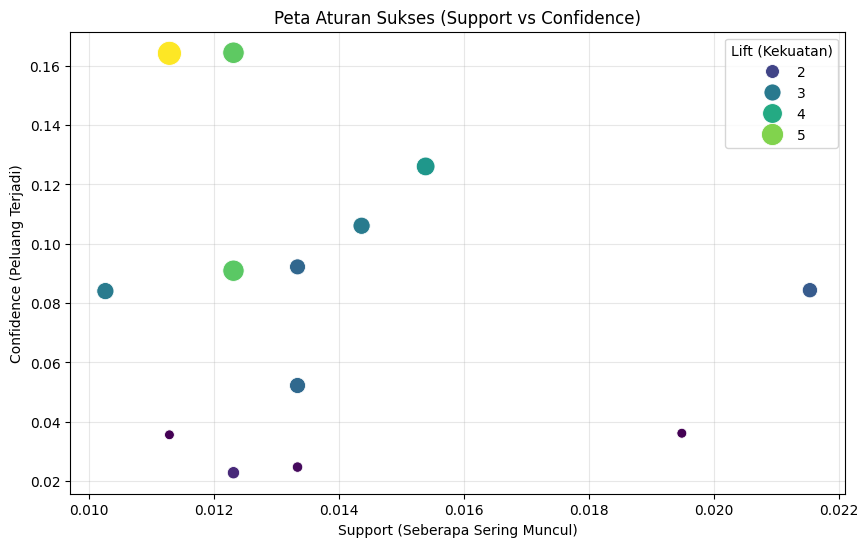

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=success_rules, x="support", y="confidence", size="lift", hue="lift", sizes=(50, 300), palette="viridis")
plt.title('Peta Aturan Sukses (Support vs Confidence)')
plt.xlabel('Support (Seberapa Sering Muncul)')
plt.ylabel('Confidence (Peluang Terjadi)')
plt.legend(title='Lift (Kekuatan)')
plt.grid(True, alpha=0.3)
plt.show()

### Result

In [19]:
print("\n=== TOP 10 RESEP RAHASIA SUKSES (Berdasarkan LIFT tertinggi) ===")
display(final_table.head(10))


=== TOP 10 RESEP RAHASIA SUKSES (Berdasarkan LIFT tertinggi) ===


,Sebab (Antecedents),Akibat (Consequents),support,confidence,lift
7,Platform_3DS,Cluster_Label_High Sales / Hit,0.011282,0.164179,5.928690
594,"Score_Category_Score_Mid, Genre_Shooter",Cluster_Label_Massive / Blockbuster,0.012308,0.164384,4.713940
598,Genre_Shooter,"Score_Category_Score_Mid, Cluster_Label_Massiv...",0.012308,0.090909,4.665072
150,Score_Category_Score_High,Cluster_Label_Massive / Blockbuster,0.015385,0.126050,3.614681
126,Genre_Shooter,Cluster_Label_Massive / Blockbuster,0.014359,0.106061,3.041444
148,Score_Category_Score_High,Cluster_Label_High Sales / Hit,0.010256,0.084034,3.034547
347,Platform_PS4,"Score_Category_Score_Mid, Cluster_Label_Massiv...",0.013333,0.052209,2.679138
344,"Platform_PS4, Score_Category_Score_Mid",Cluster_Label_Massive / Blockbuster,0.013333,0.092199,2.643930
44,Platform_PS4,Cluster_Label_Massive / Blockbuster,0.021538,0.084337,2.418498
597,Score_Category_Score_Mid,"Genre_Shooter, Cluster_Label_Massive / Blockbu...",0.012308,0.022814,1.588810


### Save Association Rule Data to CSV File

In [20]:
os.makedirs('../dataset', exist_ok=True)
output_path = '../dataset/rules_success_factors.csv'
final_table.to_csv(output_path, index=False)

print(f"\nRules tersimpan di: {output_path}")


Rules tersimpan di: ../dataset/rules_success_factors.csv
